# **Multiple Regression Analysis**

The Effect of Marketing Experience on Customer Loyalty in Thai Café Businesses: A Comparative Analysis of SMEs and Large Chains
Chananchida Siriouychai 2641729

In [ ]:
#import libraries

%pip install xlsxwriter
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from patsy import dmatrix, EvalFactor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

In [ ]:
INPUT_PATH = "regression_moderation.xls"
SHEET_NAME = 0

COLS = dict(
    y="MeanCL",
    SE="MeanSE",
    PF="MeanPF",
    CV="MeanCV",
    CSR="MeanCSR",
    BT="MeanBT",
    CafeType="CafeTyp",
    Gender="Gender",
    Age="Age",
    MonthlyIncome="MonthlyIncome",
    Occupation="Occupation",
    Frequency="Frequency",
    Spend="Spend",
    Channel="Channel",
)


def _read_excel(path, sheet):
    try:
        return pd.read_excel(path, sheet_name=sheet)
    except Exception:
        if path.lower().endswith(".xls"):
            return pd.read_excel(path, sheet_name=sheet, engine="xlrd")
        else:
            return pd.read_excel(path, sheet_name=sheet, engine="openpyxl")

df = _read_excel(INPUT_PATH, SHEET_NAME)
df

,Gender,Age,MonthlyIncome,Occupation,Frequency,Spend,Channel,CafeTyp,SE1,SE2,...,PF_c,CV_c,CSR_c,BT_c,CL_c,SExCafeTyp,PFxCafeTyp,CVxCafeTyp,CSRxCafeTyp,BTxCafeTyp
0,0,0,3,4,2,2,0,0,3,2,...,-0.039800,-0.734367,0.272033,-0.3419,-0.0815,0.0000,0.000000,0.000000,0.000000,0.0000
1,0,0,3,1,0,2,1,1,4,3,...,-0.039800,-0.401033,-1.061300,-0.0919,-0.0815,-0.2976,-0.039800,-0.401033,-1.061300,-0.0919
2,1,0,1,1,0,2,3,1,3,3,...,-0.039800,-0.401033,-1.061300,-0.0919,0.4185,-0.6726,-0.039800,-0.401033,-1.061300,-0.0919
3,0,2,1,0,0,2,2,0,4,5,...,0.960200,0.932300,-1.061300,-0.0919,-0.5815,0.0000,0.000000,0.000000,0.000000,0.0000
4,0,0,2,1,0,2,1,0,4,4,...,0.293533,0.265633,0.272033,0.1581,0.1685,0.0000,0.000000,0.000000,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,0,1,2,1,0,2,3,1,4,5,...,-0.039800,-0.067700,0.605367,-0.0919,0.1685,-0.0476,-0.039800,-0.067700,0.605367,-0.0919
306,0,0,2,1,0,2,3,1,4,4,...,0.293533,-0.734367,0.605367,0.1581,0.1685,0.2024,0.293533,-0.734367,0.605367,0.1581
307,0,1,2,1,0,0,3,1,4,4,...,-0.039800,-0.734367,-0.061300,-0.0919,-0.0815,-0.1726,-0.039800,-0.734367,-0.061300,-0.0919
308,0,2,3,1,2,0,3,1,4,5,...,-0.039800,0.598967,-0.061300,0.4081,0.4185,0.4524,-0.039800,0.598967,-0.061300,0.4081


In [ ]:
# Ensure numeric types
for role, col in COLS.items():
    if col not in df.columns:
        raise KeyError(f"Column '{col}' ({role}) not found. Available: {list(df.columns)}")
    if df[col].dtype.kind not in "biufc":
        df[col] = pd.to_numeric(df[col], errors="coerce")

y   = COLS["y"]
se  = COLS["SE"]; pf = COLS["PF"]; cv = COLS["CV"]; csr = COLS["CSR"]; bt = COLS["BT"]
cft = COLS["CafeType"]
gnd = COLS["Gender"]; age = COLS["Age"]; inc = COLS["MonthlyIncome"]; occ = COLS["Occupation"]
frq = COLS["Frequency"]; spd = COLS["Spend"]; chn = COLS["Channel"]


def Q(col): return f'Q("{col}")'
def Cq(col): return f'C({Q(col)})'

#  Build formulas
controls_cat = [f"C({gnd})", f"C({age})", f"C({inc})", f"C({occ})",
                f"C({frq})", f"C({spd})", f"C({chn})"]
main_terms = [se, pf, cv, csr, bt, f"C({cft})"]
inter_terms = [f'{v}:C({cft})' for v in [se, pf, cv, csr, bt]]


rhs1 = " + ".join(main_terms + controls_cat)
rhs2 = " + ".join(main_terms + controls_cat + inter_terms)

formula1 = f'{y} ~ {rhs1}'
formula2 = f'{y} ~ {rhs2}'

print("Model 1 formula:\n", formula1)
print("\nModel 2 formula:\n", formula2)

# Fit models
m1 = smf.ols(formula=formula1, data=df).fit()
m2 = smf.ols(formula=formula2, data=df).fit()

# Formatting helpers
def stars(p):
    return "***" if p < 0.001 else ("**" if p < 0.01 else ("*" if p < 0.05 else ("†" if p < 0.10 else "")))

def cell(coef, se, p):
    return f"{coef:.3f}{stars(p)} ({se:.3f})"

def pull(model, term):
    return cell(model.params[term], model.bse[term], model.pvalues[term]) if term in model.params.index else ""

rows = []
label_map = {se:"SE", pf:"PF", cv:"CV", csr:"CSR", bt:"BT"}

# main continuous predictors
for term,label in label_map.items():
    rows.append([label, pull(m1, term), pull(m2, term)])

# CafeType main levels (categorical)
def cat_terms(model, col):
    return [t for t in model.params.index if f"C({col})" in t and ":" not in t]


for t in sorted(set(cat_terms(m1, cft) + cat_terms(m2, cft))):
    lvl = t.split("]")[-1].replace("T.","").strip()
    rows.append([f'Café Type [{lvl}]', pull(m1, t), pull(m2, t)])

# Controls (categorical)
def add_block(label, col):
    terms = sorted(set(cat_terms(m1, col) + cat_terms(m2, col)))
    if terms:
        rows.append([f"— {label} (reference omitted)", "", ""])
        for t in terms:
            lvl = t.split("]")[-1].replace("T.","").strip()
            rows.append([f"   {lvl}", pull(m1, t), pull(m2, t)])

add_block("Gender", gnd)
add_block("Age", age)
add_block("Monthly Income", inc)
add_block("Occupation", occ)
add_block("Frequency", frq)
add_block("Spend", spd)
add_block("Channel", chn)

# Interactions (only in Model 2)
tag_cafe = f"C({cft})"
inters = [t for t in m2.params.index if ":" in t and tag_cafe in t]
if inters:
    rows.append(["— Interactions with Café Type (Moderator)", "", ""])
for t in sorted(inters):
    left = t.split(":")[0]
    lvl  = t.split(":")[1].split("]")[-1].replace("T.","").strip()
    rows.append([f"{left} × Café Type[{lvl}]", "", pull(m2, t)])

# Constant
rows.append(["Constant", pull(m1, "Intercept"), pull(m2, "Intercept")])

table = pd.DataFrame(rows, columns=["Variables","Model 1","Model 2"])

# Model stats
def fstars(m): return "***" if m.f_pvalue < 0.001 else ("**" if m.f_pvalue < 0.01 else ("*" if m.f_pvalue < 0.05 else ""))

stats_block = pd.DataFrame(
    [
        ["Observations", f"{int(m1.nobs)}", f"{int(m2.nobs)}"],
        ["R² / Adj. R²", f"{m1.rsquared:.3f} / {m1.rsquared_adj:.3f}",
                          f"{m2.rsquared:.3f} / {m2.rsquared_adj:.3f}"],
        ["F-statistic",  f"{m1.fvalue:.2f}{fstars(m1)}",
                         f"{m2.fvalue:.2f}{fstars(m2)}"],
    ],
    columns=table.columns
)

final_table = pd.concat([table, pd.DataFrame([["", "", ""]], columns=table.columns), stats_block], ignore_index=True)

# VIFs for Model 1
try:
    _, X1 = dmatrix(formula1, df, return_type="dataframe")
    X1 = X1.loc[:, [c for c in X1.columns if "Intercept" not in c]]
    vif_df = pd.DataFrame({"Term": X1.columns,
                           "VIF": [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]})
except Exception as e:
    vif_df = pd.DataFrame({"Note":[f"VIF skipped: {e}"]})

# Save
OUT_PATH = "regression_results_with_controls_and_interactions.xlsx"
with pd.ExcelWriter(OUT_PATH, engine="xlsxwriter") as writer:
    final_table.to_excel(writer, sheet_name="Regression Table", index=False)
    vif_df.to_excel(writer, sheet_name="VIFs (Model 1)", index=False)

print("Saved:", OUT_PATH)
print(final_table.head(25).to_string(index=False))

Model 1 formula:
 MeanCL ~ MeanSE + MeanPF + MeanCV + MeanCSR + MeanBT + C(CafeTyp) + C(Gender) + C(Age) + C(MonthlyIncome) + C(Occupation) + C(Frequency) + C(Spend) + C(Channel)

Model 2 formula:
 MeanCL ~ MeanSE + MeanPF + MeanCV + MeanCSR + MeanBT + C(CafeTyp) + C(Gender) + C(Age) + C(MonthlyIncome) + C(Occupation) + C(Frequency) + C(Spend) + C(Channel) + MeanSE:C(CafeTyp) + MeanPF:C(CafeTyp) + MeanCV:C(CafeTyp) + MeanCSR:C(CafeTyp) + MeanBT:C(CafeTyp)
Saved: regression_results_with_controls_and_interactions.xlsx
                           Variables          Model 1          Model 2
                                  SE  0.248** (0.075)   0.199* (0.096)
                                  PF  0.144** (0.044) 0.275*** (0.069)
                                  CV    0.001 (0.043)   -0.032 (0.062)
                                 CSR   0.092* (0.042)   0.149* (0.063)
                                  BT   0.118* (0.054)    0.064 (0.073)
                        Café Type []   0.080* (0.031

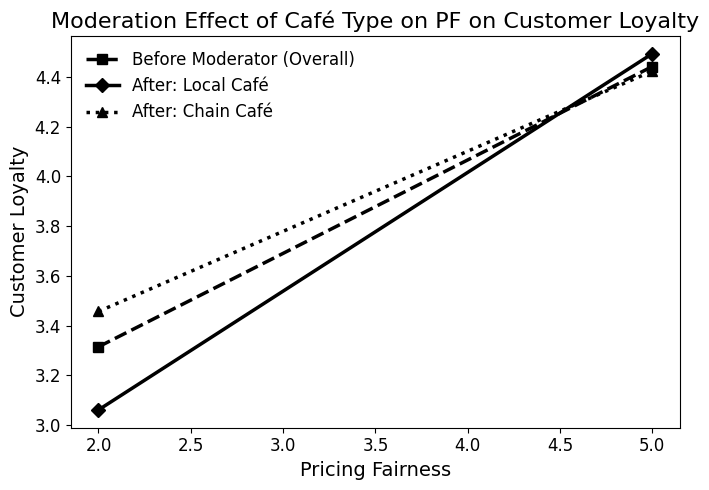

In [ ]:
#Build Interaction Plot
plt.rcParams["font.family"] = "Times New Roman"

try:
    df
except NameError:
    INPUT_PATH = "regression_moderation.xls" # or .xlsx
    SHEET_NAME = 0
    try:
        df = pd.read_excel(INPUT_PATH, sheet_name=SHEET_NAME)
    except Exception:
        if INPUT_PATH.lower().endswith(".xls"):
            df = pd.read_excel(INPUT_PATH, sheet_name=SHEET_NAME, engine="xlrd")
        else:
            df = pd.read_excel(INPUT_PATH, sheet_name=SHEET_NAME, engine="openpyxl")


y = "MeanCL"
x = "MeanPF"
moderator = "CafeTyp"

# Model 1 (no moderator)
m1 = smf.ols(f"{y} ~ {x}", data=df).fit()

# Model 2 (with moderator)
m2 = smf.ols(f"{y} ~ {x} * C({moderator})", data=df).fit()

# Range of PF values for plotting
x_range = np.linspace(df[x].min(), df[x].max(), 50)

# Predictions (Model 1: no moderator)
pred_m1 = m1.predict(pd.DataFrame({x: x_range}))

# Predictions (Model 2: with moderator)
mod_levels = sorted(df[moderator].unique())
pred_m2 = {}
for level in mod_levels:
  data_temp = pd.DataFrame({x: x_range, moderator: [level]*len(x_range)})
  pred_m2[level] = m2.predict(data_temp)


plt.figure(figsize=(7,5))

# Before moderator
plt.plot(x_range, pred_m1, label="Before Moderator (Overall)",
         color="black", linestyle="--", linewidth=2.5,
         marker="s", markevery=[0, -1], markersize=7)

# After moderator
plt.plot(x_range, pred_m2[0], label="After: Local Café",
         color="black", linestyle="-", linewidth=2.5,
         marker="D", markevery=[0, -1], markersize=7)

plt.plot(x_range, pred_m2[1], label="After: Chain Café",
         color="black", linestyle=":", linewidth=2.5,
         marker="^", markevery=[0, -1], markersize=7)

#
plt.xlabel("Pricing Fairness", fontsize=14)
plt.ylabel("Customer Loyalty", fontsize=14)
plt.title("Moderation Effect of Café Type on PF on Customer Loyalty", fontsize=16)
plt.legend(frameon=False, fontsize=12, loc="upper left")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("interaction_plot.png", dpi=300)
plt.show()